# Einops tutorial, part 1: basics

<!-- <img src='http://arogozhnikov.github.io/images/einops/einops_logo_350x350.png' height="80" /> -->

## Welcome to einops-land!

We don't write 
```python
y = x.transpose(0, 2, 3, 1)
```
We write comprehensible code
```python
y = rearrange(x, 'b c h w -> b h w c')
```


`einops` supports widely used tensor packages (such as `numpy`, `pytorch`, `jax`, `tensorflow`), and extends them.

## What's in this tutorial?

- fundamentals: reordering, composition and decomposition of axes
- operations: `rearrange`, `reduce`, `repeat`
- how much you can do with a single operation!


## Preparations

In [1]:
# Examples are given for numpy. This code also setups ipython/jupyter
# so that numpy arrays in the output are displayed as images
import numpy
from utils import display_np_arrays_as_images

display_np_arrays_as_images()

## Load a batch of images to play with

In [2]:
ims = numpy.load("./resources/test_images.npy", allow_pickle=False)
# There are 6 images of shape 96x96 with 3 color channels packed into tensor
print(ims.shape, ims.dtype)

(6, 96, 96, 3) float64


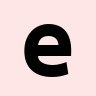

In [3]:
# display the first image (whole 4d tensor can't be rendered)
ims[0]

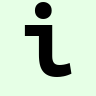

In [4]:
# second image in a batch
ims[1]

In [5]:
# we'll use three operations
from einops import rearrange, reduce, repeat

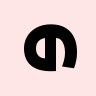

In [6]:
# rearrange, as the name suggests, rearranges elements
# below we swapped height and width.
# In other words, transposed first two axes (dimensions)
rearrange(ims[0], "h w c -> w h c")

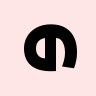

In [7]:
# we could use more verbose names for axes, and result is the same:
rearrange(ims[0], "height width color -> width height color")
# when you operate on same set of axes many times,
# you usually come up with short names.
# That's what we do throughout tutorial - we'll use b (for batch), h, w, and c

## Composition of axes
transposition is very common and useful, but let's move to other capabilities provided by einops

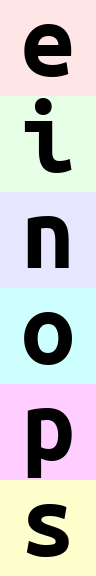

In [8]:
# einops allows seamlessly composing batch and height to a new height dimension
# We just rendered all images by collapsing to 3d tensor!
rearrange(ims, "b h w c -> (b h) w c")

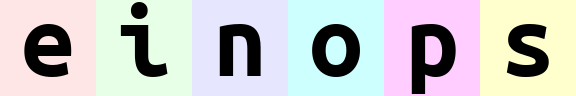

In [9]:
# or compose a new dimension of batch and width
rearrange(ims, "b h w c -> h (b w) c")

In [10]:
# resulting dimensions are computed very simply
# length of newly composed axis is a product of components
# [6, 96, 96, 3] -> [96, (6 * 96), 3]
rearrange(ims, "b h w c -> h (b w) c").shape

(96, 576, 3)

In [11]:
# we can compose more than two axes.
# let's flatten 4d array into 1d, resulting array has as many elements as the original
rearrange(ims, "b h w c -> (b h w c)").shape

(165888,)

### play

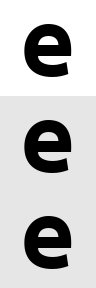

In [12]:
# compose dimension of colour channels and height
rearrange(ims[0], "h w c -> (c h) w")

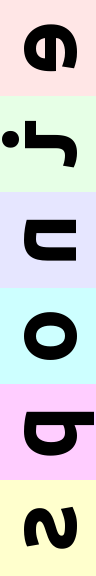

In [13]:
# compose batch and width into a single vertical dimension, height as horizontal dimension
rearrange(ims, "b h w c -> (b w) h c")

## Decomposition of axis

In [14]:
# decomposition is the inverse process - represent an axis as a combination of new axes
# several decompositions possible, so b1=2 is to decompose 6 to b1=2 and b2=3
rearrange(ims, "(b1 b2) h w c -> b1 b2 h w c ", b1=2).shape

(2, 3, 96, 96, 3)

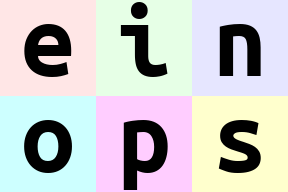

In [15]:
# finally, combine composition and decomposition:
rearrange(ims, "(b1 b2) h w c -> (b1 h) (b2 w) c ", b1=2)

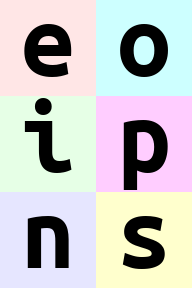

In [16]:
# slightly different composition: b1 is merged with width, b2 with height
# ... so letters are ordered by w then by h
rearrange(ims, "(b1 b2) h w c -> (b2 h) (b1 w) c ", b1=2)

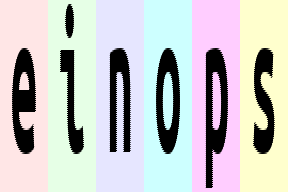

In [17]:
# move part of width dimension to height.
# we should call this width-to-height as image width shrunk by 2 and height doubled.
# but all pixels are the same!
# Can you write reverse operation (height-to-width)?
rearrange(ims, "b h (w w2) c -> (h w2) (b w) c", w2=2)

### play

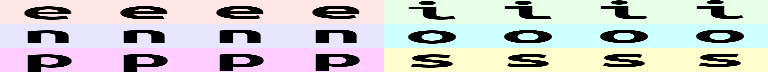

In [26]:
# merge b1 with height and b2 with width, shrink height to 24 and repeat width 4x
rearrange(ims, "(b1 b2) (h1 h2) w c -> (b1 h1) (b2 h2 w) c", b1=3, h1=24)

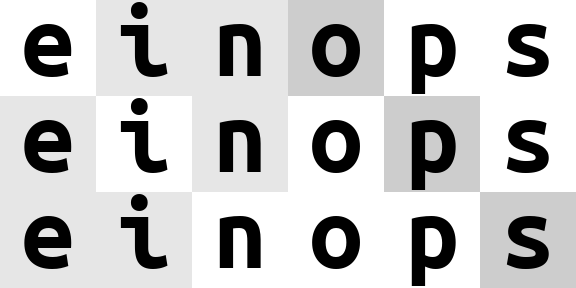

In [40]:
# combine colour and height, combine batch and width
rearrange(ims, "b h w c -> (c h) (b w)")

## Order of axes matters

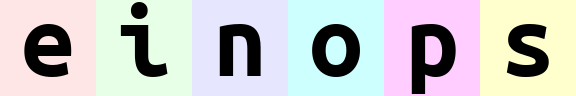

In [41]:
# compare with the next example
rearrange(ims, "b h w c -> h (b w) c")

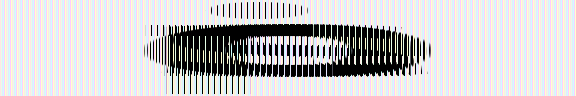

In [42]:
# order of axes in composition is different
# rule is just as for digits in the number: leftmost digit is the most significant,
# while neighboring numbers differ in the rightmost axis.

# you can also think of this as lexicographic sort
rearrange(ims, "b h w c -> h (w b) c")

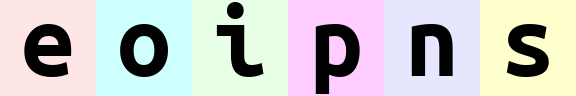

In [43]:
# what if b1 and b2 are reordered before composing to width?
rearrange(ims, "(b1 b2) h w c -> h (b1 b2 w) c ", b1=2)  # produces 'einops'
rearrange(ims, "(b1 b2) h w c -> h (b2 b1 w) c ", b1=2)  # produces 'eoipns'

## Meet einops.reduce

In einops-land you don't need to guess what happened
```python
x.mean(-1)
```
Because you write what the operation does
```python
reduce(x, 'b h w c -> b h w', 'mean')
```

if axis is not present in the output — you guessed it — axis was reduced.

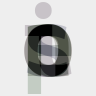

In [19]:
# average over batch
reduce(ims, "b h w c -> h w c", "mean")

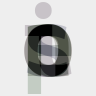

In [20]:
# the previous is identical to familiar:
ims.mean(axis=0)
# but is so much more readable

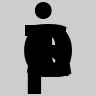

In [21]:
# Example of reducing of several axes
# besides mean, there are also min, max, sum, prod
reduce(ims, "b h w c -> h w", "min")

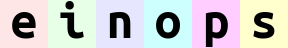

In [22]:
# this is mean-pooling with 2x2 kernel
# image is split into 2x2 patches, each patch is averaged
reduce(ims, "b (h h2) (w w2) c -> h (b w) c", "mean", h2=2, w2=2)

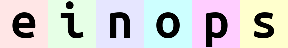

In [23]:
# max-pooling is similar
# result is not as smooth as for mean-pooling
reduce(ims, "b (h h2) (w w2) c -> h (b w) c", "max", h2=2, w2=2)

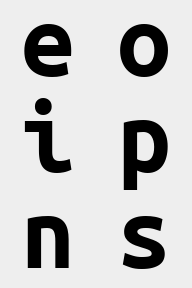

In [24]:
# yet another example. Can you compute result shape?
reduce(ims, "(b1 b2) h w c -> (b2 h) (b1 w)", "mean", b1=2)

## Stack and concatenate

In [25]:
# rearrange can also take care of lists of arrays with the same shape
x = list(ims)
print(type(x), "with", len(x), "tensors of shape", x[0].shape)
# that's how we can stack inputs
# "list axis" becomes first ("b" in this case), and we left it there
rearrange(x, "b h w c -> b h w c").shape

<class 'list'> with 6 tensors of shape (96, 96, 3)


(6, 96, 96, 3)

In [26]:
# but new axis can appear in the other place:
rearrange(x, "b h w c -> h w c b").shape

(96, 96, 3, 6)

In [27]:
# that's equivalent to numpy stacking, but written more explicitly
numpy.array_equal(rearrange(x, "b h w c -> h w c b"), numpy.stack(x, axis=3))

True

In [28]:
# ... or we can concatenate along axes
rearrange(x, "b h w c -> h (b w) c").shape

(96, 576, 3)

In [29]:
# which is equivalent to concatenation
numpy.array_equal(rearrange(x, "b h w c -> h (b w) c"), numpy.concatenate(x, axis=1))

True

## Addition or removal of axes

You can write 1 to create a new axis of length 1. Similarly you can remove such axis.

There is also a synonym `()` that you can use. That's a composition of zero axes and it also has a unit length.

In [30]:
x = rearrange(ims, "b h w c -> b 1 h w 1 c")  # functionality of numpy.expand_dims
print(x.shape)
print(rearrange(x, "b 1 h w 1 c -> b h w c").shape)  # functionality of numpy.squeeze

(6, 1, 96, 96, 1, 3)
(6, 96, 96, 3)


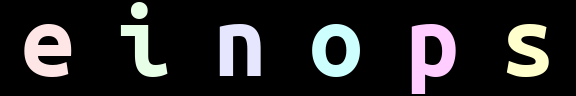

In [31]:
# compute max in each image individually, then show a difference
x = reduce(ims, "b h w c -> b () () c", "max") - ims
rearrange(x, "b h w c -> h (b w) c")

## Repeating elements

Third operation we introduce is `repeat`

In [32]:
# repeat along a new axis. New axis can be placed anywhere
repeat(ims[0], "h w c -> h new_axis w c", new_axis=5).shape

(96, 5, 96, 3)

In [33]:
# shortcut
repeat(ims[0], "h w c -> h 5 w c").shape

(96, 5, 96, 3)

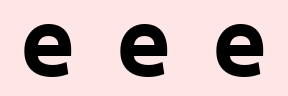

In [34]:
# repeat along w (existing axis)
repeat(ims[0], "h w c -> h (repeat w) c", repeat=3)

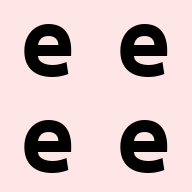

In [35]:
# repeat along two existing axes
repeat(ims[0], "h w c -> (2 h) (2 w) c")

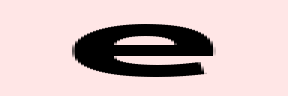

In [36]:
# order of axes matters as usual - you can repeat each element (pixel) 3 times
# by changing order in parenthesis
repeat(ims[0], "h w c -> h (w repeat) c", repeat=3)

Note: `repeat` operation covers functionality identical to `numpy.repeat`, `numpy.tile` and actually more than that.

## Reduce ⇆ repeat

reduce and repeat are like opposite of each other: first one reduces amount of elements, second one increases.

In the following example each image is repeated first, then we reduce over new axis to get back original tensor. Notice that operation patterns are "reverse" of each other

In [37]:
repeated = repeat(ims, "b h w c -> b h new_axis w c", new_axis=2)
reduced = reduce(repeated, "b h new_axis w c -> b h w c", "min")
assert numpy.array_equal(ims, reduced)

## Fancy examples in random order

(a.k.a. mad designer gallery)

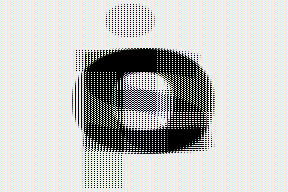

In [38]:
# interweaving pixels of different pictures
# all letters are observable
rearrange(ims, "(b1 b2) h w c -> (h b1) (w b2) c ", b1=2)

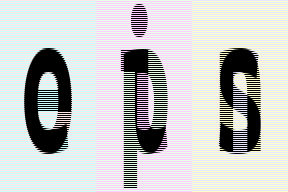

In [39]:
# interweaving along vertical for couples of images
rearrange(ims, "(b1 b2) h w c -> (h b1) (b2 w) c", b1=2)

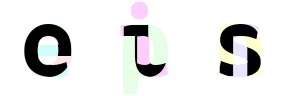

In [40]:
# interweaving lines for couples of images
# exercise: achieve the same result without einops in your favourite framework
reduce(ims, "(b1 b2) h w c -> h (b2 w) c", "max", b1=2)

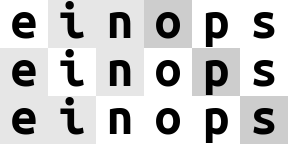

In [41]:
# color can be also composed into dimension
# ... while image is downsampled
reduce(ims, "b (h 2) (w 2) c -> (c h) (b w)", "mean")

In [42]:
# disproportionate resize
reduce(ims, "b (h 4) (w 3) c -> (h) (b w)", "mean")

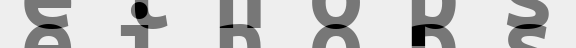

In [43]:
# spilt each image in two halves, compute mean of the two
reduce(ims, "b (h1 h2) w c -> h2 (b w)", "mean", h1=2)

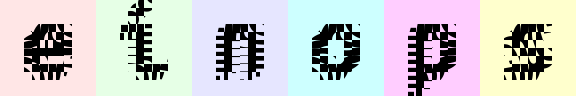

In [44]:
# split in small patches and transpose each patch
rearrange(ims, "b (h1 h2) (w1 w2) c -> (h1 w2) (b w1 h2) c", h2=8, w2=8)

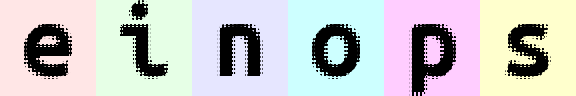

In [45]:
# stop me someone!
rearrange(ims, "b (h1 h2 h3) (w1 w2 w3) c -> (h1 w2 h3) (b w1 h2 w3) c", h2=2, w2=2, w3=2, h3=2)

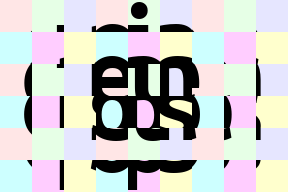

In [46]:
rearrange(ims, "(b1 b2) (h1 h2) (w1 w2) c -> (h1 b1 h2) (w1 b2 w2) c", h1=3, w1=3, b2=3)

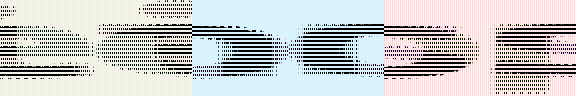

In [47]:
# patterns can be arbitrarily complicated
reduce(ims, "(b1 b2) (h1 h2 h3) (w1 w2 w3) c -> (h1 w1 h3) (b1 w2 h2 w3 b2) c", "mean", h2=2, w1=2, w3=2, h3=2, b2=2)

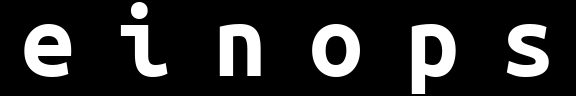

In [48]:
# subtract background in each image individually and normalize
# pay attention to () - this is composition of 0 axis, a dummy axis with 1 element.
im2 = reduce(ims, "b h w c -> b () () c", "max") - ims
im2 /= reduce(im2, "b h w c -> b () () c", "max")
rearrange(im2, "b h w c -> h (b w) c")

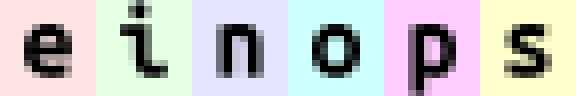

In [49]:
# pixelate: first downscale by averaging, then upscale back using the same pattern
averaged = reduce(ims, "b (h h2) (w w2) c -> b h w c", "mean", h2=6, w2=8)
repeat(averaged, "b h w c -> (h h2) (b w w2) c", h2=6, w2=8)

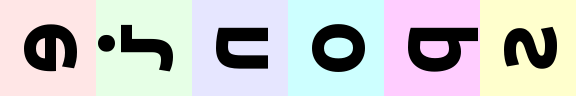

In [50]:
rearrange(ims, "b h w c -> w (b h) c")

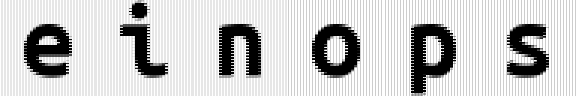

In [51]:
# let's bring color dimension as part of horizontal axis
# at the same time horizontal axis is downsampled by 2x
reduce(ims, "b (h h2) (w w2) c -> (h w2) (b w c)", "mean", h2=3, w2=3)

## Ok, numpy is fun, but how do I use einops with some other framework?

If that's what you've done with `ims` being numpy array:
```python
rearrange(ims, 'b h w c -> w (b h) c')
```
That's how you adapt the code for other frameworks:

```python
# pytorch:
rearrange(ims, 'b h w c -> w (b h) c')
# tensorflow:
rearrange(ims, 'b h w c -> w (b h) c')
# gluon:
rearrange(ims, 'b h w c -> w (b h) c')
# cupy:
rearrange(ims, 'b h w c -> w (b h) c')
# jax:
rearrange(ims, 'b h w c -> w (b h) c')
# paddle:
rearrange(ims, 'b h w c -> w (b h) c')

...well, you got the idea.
```

Einops allows backpropagation as if all operations were native to framework.
Operations do not change when moving to another framework - einops notation is universal

# Summary

- `rearrange` doesn't change number of elements and covers different numpy functions (like `transpose`, `reshape`, `stack`, `concatenate`,  `squeeze` and `expand_dims`)
- `reduce` combines same reordering syntax with reductions (`mean`, `min`, `max`, `sum`, `prod`, and any others)
- `repeat` additionally covers repeating and tiling
- composition and decomposition of axes are a corner stone, they can and should be used together



- [Second part of tutorial](https://github.com/arogozhnikov/einops/tree/main/docs) shows how einops works with other frameworks
- [Third part of tutorial](https://arogozhnikov.github.io/einops/pytorch-examples.html) shows how to improve your DL code with einops